<a href="https://colab.research.google.com/github/100rab-S/Fun-With-MNIST/blob/main/MNIST-3/V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/MyDrive/Fun With MNIST/MNIST-3(Localization)

/content/drive/MyDrive/Fun With MNIST/MNIST-3(Localization)


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Input, Lambda, Flatten
from tensorflow.image import draw_bounding_boxes
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

import logging  
import os

In [ ]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
# print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.25.254.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.254.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.25.254.178:8470']
Number of accelerators:  8


In [ ]:
batch_size = 64
BATCH_SIZE = batch_size * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

In [ ]:
# BATCH_SIZE = 512

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# X_train, y_train, X_test, y_test = X_train[:45000], y_train[:45000], X_test[:45000], y_test[:45000]

7


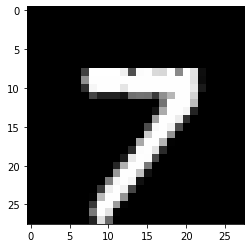

In [ ]:
def display_random_digit():
    random = np.random.randint(len(X_train))
    random_image = X_train[random]
    plt.imshow(random_image, cmap = 'gray')
    print(y_train[random])

display_random_digit()

In [ ]:
def print_shape():
    print('Shape of the training dataset:')
    print(X_train.shape, y_train.shape)
    print('\nShape of the test dataset:')
    print(X_test.shape, y_test.shape)

print_shape()

Shape of the training dataset:
(60000, 28, 28) (60000,)

Shape of the test dataset:
(10000, 28, 28) (10000,)


In [ ]:
def preprocess_dataset(images, labels):
    '''
    This function randomly places 28*28 image in 75*75 canvas and also saves the bounding box co-ordinates.
    '''
    w, h = images.shape[1], images.shape[2]

    boxes_coordinates = []
    new_images = []

    for image in images:
        
        canvas = np.zeros((75, 75))
        rand_width, rand_height = np.random.randint(48, size=2) # 75-28 = 47

        div = 75 # to normalize the values
        temp = [rand_width/div, rand_height/div, (rand_width+28)/div, (rand_height+28)/div] # width is like row 
                                                            # and height is like column for the matrix.
        boxes_coordinates.append(temp)

        canvas[rand_width:rand_width+28, rand_height:rand_height+28] = image
        new_images.append(canvas)

    new_images = np.array(new_images)
    new_images = np.expand_dims(new_images,axis = -1) # to make a 3D grayscale image 

    boxes_coordinates = np.array(boxes_coordinates)
    labels = np.array(labels)

    return new_images, labels, boxes_coordinates

def display_bound_boxes(images, boxes):
    '''
    Displays images with bounding boxes.
    '''
    images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images)).numpy()
    boxes = np.expand_dims(boxes, axis = 1)
    color = np.array([[1.0, 0.0, 0.0], [2.0, 0.0, 0.0]])

    images = draw_bounding_boxes(images, boxes, colors=color)

    nrows = np.ceil(len(images)/10).astype(int)
    # figure = plt.figure(figsize=(10, len(images)))
    fig, axes = plt.subplots(nrows, 10, figsize = (20, 2*nrows), sharex = True, sharey=True)
    for ax, image in zip(axes.ravel(), images):
        # image = tf.cast(image*255, tf.uint8) # to remove the warnings but the colour of image changes
                          #to remove the warnings but the colour of image changes

        logger = logging.getLogger()
        old_level = logger.level
        logger.setLevel(100)

        ax.imshow(image, cmap = 'gray')

        logger.setLevel(old_level)

In [ ]:
X_train, y_train, y_train_boxes = preprocess_dataset(X_train, y_train)
X_test, y_test, y_test_boxes = preprocess_dataset(X_test, y_test)
print_shape()

Shape of the training dataset:
(60000, 75, 75, 1) (60000,)

Shape of the test dataset:
(10000, 75, 75, 1) (10000,)


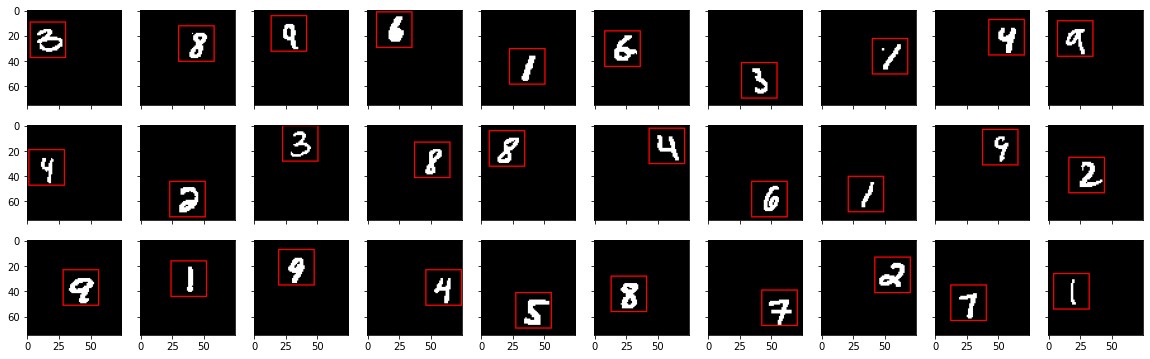

In [ ]:
indices = np.random.randint(len(X_train), size = 30)
display_bound_boxes(X_train[indices], y_train_boxes[indices])

In [ ]:
# convert numpy arrays into tensor datasets

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, y_train_boxes))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test, y_test_boxes))

In [ ]:
# more preprocessing on the dataset

def create_dataset(image, label, box):
    # label = list(label)
    image = tf.cast(image, tf.float32)/255.0
    # image = tf.reshape(image, (75, 75))
    box = tf.cast(box, tf.float32)
    label = tf.cast(label, tf.uint8)
    label = tf.one_hot(label, 10)

    return image, (label, box)

In [ ]:
train_dataset = train_dataset.map(create_dataset)
valid_dataset = valid_dataset.map(create_dataset)

train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE, drop_remainder = True).prefetch(-1)
valid_dataset = valid_dataset.shuffle(1024).batch(BATCH_SIZE, drop_remainder = True).prefetch(-1)

In [ ]:
# define model

def feature_extractor(inputs):
    x = Conv2D(32, 3, padding = 'same', activation='relu')(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(32, 3, activation='relu', padding = 'same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    return x

def dense_part(inputs):
    x = Flatten()(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    return x

def classifier_output(inputs):
    output = Dense(10, activation='softmax', name = 'Classifier')(inputs)

    return output

def regressor_output(inputs):
    x = Dense(64, activation = 'relu')(inputs)
    x = Dense(10, activation = 'relu')(x)
    output = Dense(4, activation = 'relu', name = 'Regressor')(x)

    return output

# @tf.function
def myModel():
    input = Input(shape = (75, 75, 1))

    extractor_ouptput = feature_extractor(input)
    dense_output = dense_part(extractor_ouptput)
    output1 = classifier_output(dense_output)
    output2 = regressor_output(dense_output)

    model = Model(input, [output1, output2])

    return model


In [ ]:
# with strategy.scope():
model = myModel()
model.compile(optimizer='adam', 
            loss = {'Classifier' : 'categorical_crossentropy',
                    'Regressor' : 'mse'
                    },
            metrics = ['accuracy'])
            #   metrics = {'Classifier' : 'accuracy',
            #              'Regressor' : 'mse'
            #             })

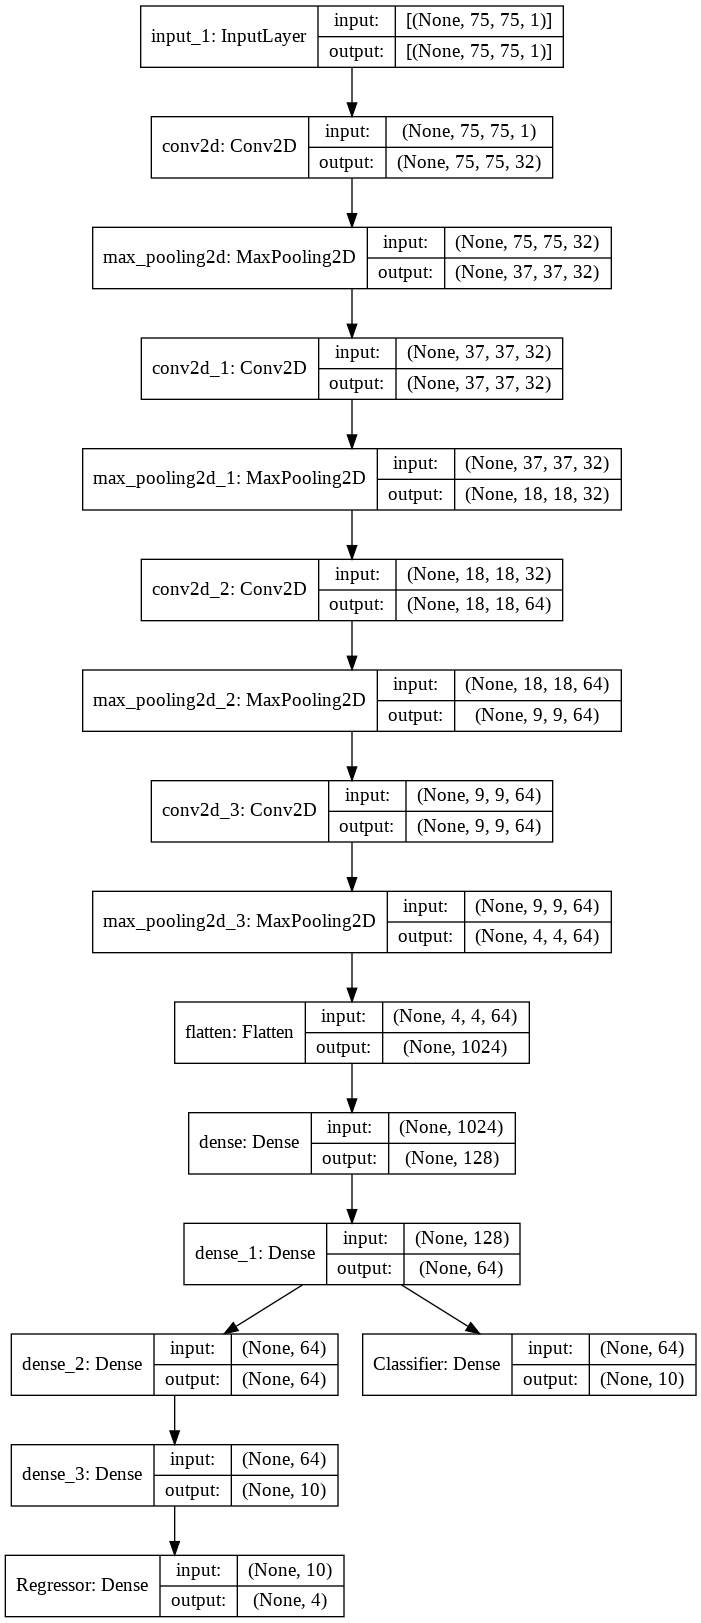

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
def print_evaluate():
    train_c_acc = hist.history['Classifier_accuracy']
    train_r_acc = hist.history['Regressor_accuracy']
    train_loss = hist.history['loss']

    valid_c_acc = hist.history['val_Classifier_accuracy']
    valid_r_acc = hist.history['val_Regressor_accuracy']
    valid_loss = hist.history['val_loss']
    epochs = range(len(train_c_acc))

    plt.plot(epochs, train_c_acc, 'r', label = 'Train Classifier Accuracy',)
    plt.plot(epochs, valid_c_acc, 'b', label = 'Validation Classifier Accuracy')
    # plt.plot(epochs, 0.75, 'y', label = 'Boundary')
    plt.legend()
    plt.title('Classifier Accuracy')
    plt.show()

    plt.plot(epochs, train_r_acc, 'r', label = 'Train Regressor Accuracy',)
    plt.plot(epochs, valid_r_acc, 'b', label = 'Validation Regressor Accuracy')
    # plt.plot(epochs, 0.75, 'y', label = 'Boundary')
    plt.legend()
    plt.title('Regressor Accuracy')
    plt.show()

    plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
    plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    # loss, accuracy = model.evaluate(test_generator, batch_size = batch_size)
    # print(loss)
    # print(int(accuracy * 100), '%')

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_Regressor_accuracy', min_delta = 0.01, patience=10, restore_best_weights=True)

In [ ]:
epochs = 100
hist = model.fit(train_dataset, epochs = epochs, validation_data=valid_dataset, callbacks=[es])

Epoch 1/100
87/87 [==============================] - 41s 89ms/step - loss: 2.2994 - Classifier_loss: 2.2523 - Regressor_loss: 0.0471 - Classifier_accuracy: 0.1448 - Regressor_accuracy: 0.8136 - val_loss: 1.5051 - val_Classifier_loss: 1.4883 - val_Regressor_loss: 0.0168 - val_Classifier_accuracy: 0.4560 - val_Regressor_accuracy: 0.8376
Epoch 2/100
87/87 [==============================] - 7s 82ms/step - loss: 1.0990 - Classifier_loss: 1.0771 - Regressor_loss: 0.0219 - Classifier_accuracy: 0.6228 - Regressor_accuracy: 0.8013 - val_loss: 0.4380 - val_Classifier_loss: 0.4215 - val_Regressor_loss: 0.0165 - val_Classifier_accuracy: 0.8644 - val_Regressor_accuracy: 0.8131
Epoch 3/100
87/87 [==============================] - 7s 82ms/step - loss: 0.3687 - Classifier_loss: 0.3535 - Regressor_loss: 0.0152 - Classifier_accuracy: 0.8925 - Regressor_accuracy: 0.8290 - val_loss: 0.2461 - val_Classifier_loss: 0.2293 - val_Regressor_loss: 0.0169 - val_Classifier_accuracy: 0.9284 - val_Regressor_accuracy

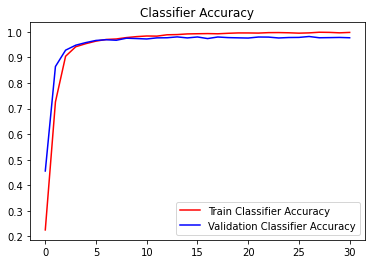

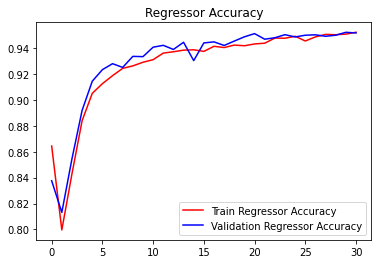

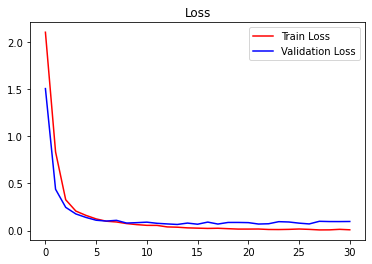

In [ ]:
print_evaluate()

In [ ]:
output = model.evaluate(valid_dataset)
print(len(output))


19/19 [==============================] - 1s 51ms/step - loss: 0.0842 - Classifier_loss: 0.0824 - Regressor_loss: 0.0018 - Classifier_accuracy: 0.9757 - Regressor_accuracy: 0.9515
5


In [ ]:
for val in output:
    print(val)

0.08424760401248932
0.08242645114660263
0.001821140176616609
0.9757401347160339
0.9514802694320679


In [ ]:
batches = 5
batch_size = 10
pred = []
test_images = []
for n, ex in enumerate(valid_dataset.unbatch().batch(batch_size).shuffle(100).as_numpy_iterator()):
    if n>=batches:
        break
    pred.append(model.predict([[ex[0]]]))
    test_images.append(ex[0])
    # print(ex[1][1].shape)
test_images = np.array(test_images).reshape((batches*batch_size, 75, 75, 1))
test_images.shape

(50, 75, 75, 1)

In [ ]:
test_boxes = []
for batch in range(batches):
    test_boxes.append(pred[batch][1])
test_boxes = np.array(test_boxes).reshape(batches*batch_size, 4)

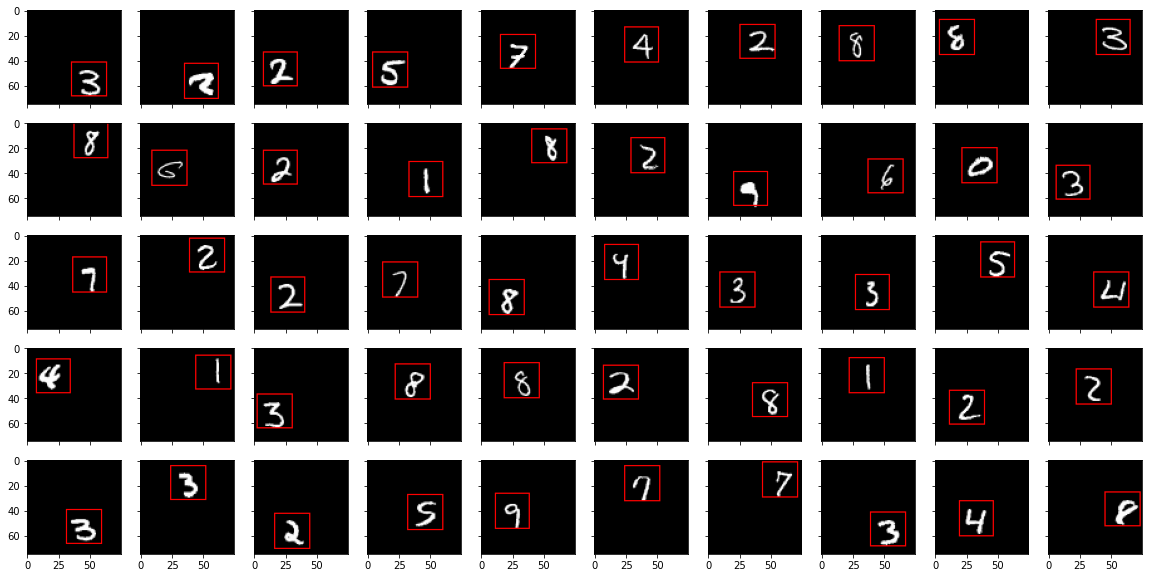

In [ ]:
# Prediction on validation dataset

display_bound_boxes(test_images, test_boxes)

In [ ]:
# model.save('mnist-3-3.h5')